**Step 004 004step wavenet training and prediction(necessary and important)(PS:Download on the server offer by the match organization is prohibit,so the effect of code is only can be showed by screenshot of running on server.)**

**The training data is input to the WaveNet model, using a two-layer 1/2/4/8 diffusion rate model, and the input and output are sequence-to-sequence modes.**

**The training data feature is the 21-day data at the end of May, the training data label is the 7-day data at the beginning of June, and the predicted data feature is the 21-day data at the end of June.**

**4 cities, 2 types of networks, all cells, 6 indicators, and 48 reports are generated by polling 48 times in the program. It takes 5 hours for 4 cores of 32G + 1 V100 training and prediction. The prediction result is 0.2560-0.2565（mape).(screenshot shown in the end of code)**

**wavenet模型训练及预测(必要且重要）（备注：因赛事方比赛服务器限制所有下载，部分代码效果只有对服务器代码运行截图显示，参见代码部分。）**

**训练数据输入模型WaveNet，采用两层的1/2/4/8扩散率模型，输入输出为序列到序列模式**

**训练数据特征为5月11日-5月31日21天数据，训练数据标签为6月1日-6月7日7天数据，预测数据特征为6月10日-6月30日21天数据。最终来预测7月1日-7月7日的数据。**

**4个城市，2种网络所有小区，6个指标，在程序中分别轮询48次生成48张报表，需要耗费4核32G + 1 V100训练和预测共用时5小时，预测结果0.2560-0.2565（mape)。(参见代码最后截图)**

In [ ]:
import pandas as pd
import numpy as np
import datetime
import os
import pickle
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import StratifiedKFold, GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
        
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
def log_txt(data_str,file_path = "./log/log_back_up_wave21newIQR5f.txt"):
    with open(file_path,"a") as file:   #只需要将之前的”w"改为“a"即可，代表追加内容
        file.write(data_str + "d" + " "+"\n")

In [ ]:
start_time = datetime.datetime.now()
log_str = 'start_time is {}'.format(start_time)
print(log_str)
log_txt(log_str)

**the start time of code running**

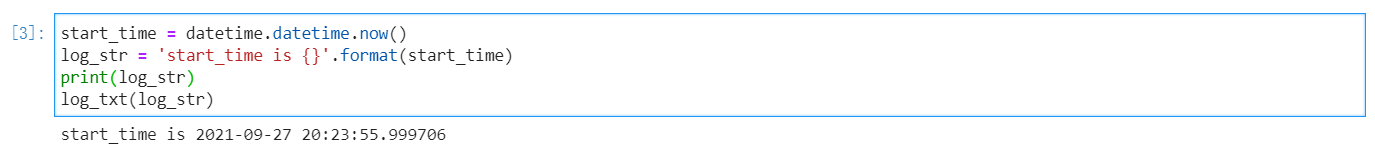

In [ ]:
city_list = ['C48FDFBFC4072E0E','AFE97F546A10368F','EA5EAA705108BDA0','F37F452354AC87C9']
timestamp_column = "TimeStamp"
userlabel_column = "UserLabel"
G4_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有效RRC连接平均数', '下行流量', '上行流量', '下行利用率PDCCH']
G5_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有数据传输的RRC数', '下行流量', '上行流量', '下行利用率PDCCH']
time_format = "%Y-%m-%d %H:%M:%S"
study_radio_dict = {'4g':{"AFE97F546A10368F":13,"C48FDFBFC4072E0E":13,"EA5EAA705108BDA0":11,"F37F452354AC87C9":3},
                   '5g':{"AFE97F546A10368F":2,"C48FDFBFC4072E0E":2,"EA5EAA705108BDA0":1,"F37F452354AC87C9":1}}
data_col_dict = {'上行利用率PUSCH':'PUSCH','下行利用率PDSCH':'PDSCH','有效RRC连接平均数':'RRC',
                             '下行流量':'PDCPDL','上行流量':'PDCPUL','下行利用率PDCCH':'PDCCH','有数据传输的RRC数':'RRC'}
data_float_dict = {'上行利用率PUSCH':'float16','下行利用率PDSCH':'float16', '有效RRC连接平均数':'float16',
                   '下行流量':'float32', '上行流量':'float32', '下行利用率PDCCH':'float16','有数据传输的RRC数':'float16'}
epochs_dict = {'4g':{"AFE97F546A10368F":50,"C48FDFBFC4072E0E":50,"EA5EAA705108BDA0":50,"F37F452354AC87C9":50},
                   '5g':{"AFE97F546A10368F":100,"C48FDFBFC4072E0E":100,"EA5EAA705108BDA0":150,"F37F452354AC87C9":200}}
patience_dict = {'4g':{"AFE97F546A10368F":5,"C48FDFBFC4072E0E":5,"EA5EAA705108BDA0":5,"F37F452354AC87C9":5},
                   '5g':{"AFE97F546A10368F":10,"C48FDFBFC4072E0E":10,"EA5EAA705108BDA0":15,"F37F452354AC87C9":20}}
n_steps = 21
n_pred = 7

In [ ]:
def pic_to_pd(file_path,select_data_column,float_type):
    print('begin to get data from {}'.format(file_path))
    file=open(file_path,'rb')
    df = pickle.load(file)
    file.close()
    select_columns = ["TimeStamp","UserLabel"]
    select_columns.append(select_data_column)
    df= df[select_columns]
    df.dropna(inplace = True)
    df.reset_index(drop = True,inplace = True)
    df[select_data_column] = df[select_data_column].astype(float_type)
    #df.loc[:,"TimeStamp_orgin"] = df[timestamp_column].apply(lambda x: datetime.datetime.strptime(x,time_format))
    return df

In [ ]:
def pic_to_pd_train(train_file_path,test_file_path,select_data_column,float_type,select_cell_list = False):
    df_train = pic_to_pd(train_file_path,select_data_column,float_type)
    df_test = pic_to_pd(test_file_path,select_data_column,float_type)
    train_cell_set = set(df_train["UserLabel"].unique())
    test_cell_set = set(df_test["UserLabel"].unique())
    if select_cell_list == False:
        choose_cell_set = list(train_cell_set & test_cell_set)
    else:
        select_cell_set = set(select_cell_list)
        choose_cell_set = list(select_cell_set & train_cell_set & test_cell_set)
    print('use to train cells num is {}'.format(len(choose_cell_set)))
    df_train = df_train.query("UserLabel in {}".format(choose_cell_set))
    df_test = df_test.query("UserLabel in {}".format(choose_cell_set))
    df = pd.concat([df_train,df_test])
    df.reset_index(drop = True,inplace = True)
    return df,choose_cell_set,len(choose_cell_set)

**As shown in the follow code,you can see matrixing transformation to make the training and prediction become n*24 hrs time sliding windows mode（shown in the screenshot and code follow,you can compare with same part of Other04)**

**下面的代码可以看到矩阵变换，使训练和预测过程变为n*24小时滑窗模式(如下图和代码所示,可与Other04同部分对比)**

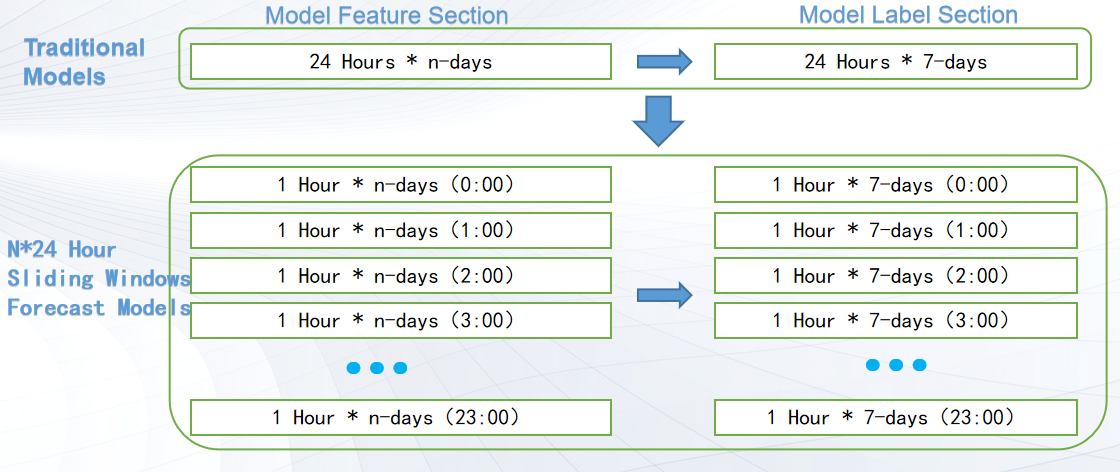

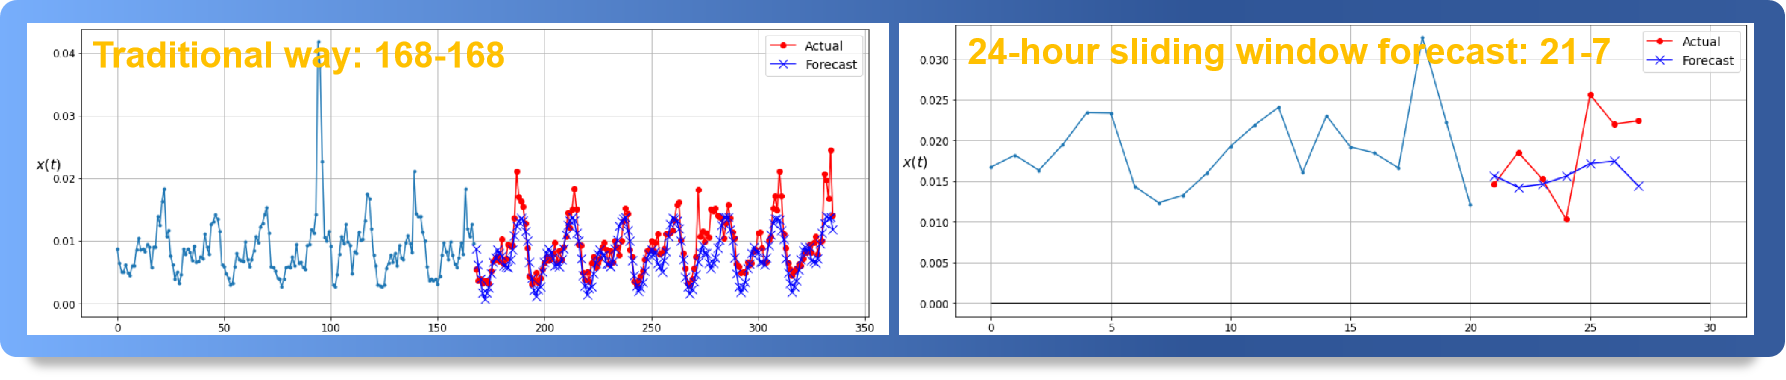

In [ ]:
def pd_to_npdata(df,select_data_column,train_month = False,user_num = False,n_steps = 21,n_pred = 7):
    print('begin to trun pandas data to train data')
    df['month'] = df['TimeStamp'].apply(lambda x: int(x[5:7]))
    if train_month == False:
        train_month == df['month'].min()
    if user_num == False:
        user_num = len(df["UserLabel"].unique())
    train_day_num = (df['month'] == train_month).sum()
    data_start_row = train_day_num - user_num * n_steps * 24
    print('data_start_row is {}'.format(data_start_row))
    data_end_row = data_start_row + user_num * (n_steps + n_pred) * 24 - 1
    print(' data_end_row is {}'.format( data_end_row))
    df = df.loc[data_start_row:data_end_row]
    df.drop('month',axis = 1)
    df.reset_index(drop = True,inplace = True)
    df['hour'] = df['TimeStamp'].apply(lambda x: int(x[11:13]))
    df.sort_values(["hour","TimeStamp","UserLabel"],inplace = True)
    df.reset_index(drop = True,inplace = True)
    print('begin to creat X_train Y_train index_Y_train')
    X_train_list = []
    Y_train_list = []
    index_Y_train_list = []
    #n*24小时滑窗模式矩阵变换
    #matrixing transformation to become n*24 hrs time sliding windows mode
    for time_order in range(24):
        print("now time_order is {}".format(time_order))
        start_row = time_order * user_num * (n_steps + n_pred)
        end_x_low = start_row + n_steps * user_num - 1
        X_train_list.append(df.loc[start_row:end_x_low,select_data_column].values.reshape(n_steps,user_num).T.reshape(user_num,n_steps,1))
        Y_train_sub_list = []
        for step_order in range(n_steps):
            start_y_row = start_row + (step_order + 1) * user_num
            end_y_low =  start_y_row + n_pred * user_num - 1
            Y_train_sub_list.append(df.loc[start_y_row:end_y_low,select_data_column].values.reshape(n_pred,user_num))
        Y_train_sub = np.concatenate(Y_train_sub_list, axis=0).T.reshape(user_num,n_steps,n_pred)
        Y_train_list.append(Y_train_sub)
        index_Y_train_list.append(df.loc[end_x_low + 1:end_x_low + user_num,["TimeStamp","UserLabel"]])
    X_train = np.concatenate(X_train_list, axis=0)
    del(X_train_list)
    Y_train = np.concatenate(Y_train_list, axis=0)
    del(Y_train_list)
    index_Y_train = pd.concat(index_Y_train_list)
    index_Y_train.reset_index(drop = True,inplace = True)
    del(index_Y_train_list)
    return X_train,Y_train,index_Y_train

In [ ]:
def pd_to_npdata_test(test_file_path,select_data_column,float_type,test_month = False,n_steps = 21):
    df = pic_to_pd(test_file_path,select_data_column,float_type)
    print('begin to trun pandas data to test data')
    df['month'] = df['TimeStamp'].apply(lambda x: int(x[5:7]))
    if test_month == False:
        test_month = df['month'].min()
    user_num = len(df["UserLabel"].unique())
    test_day_num = (df['month'] == test_month).sum()
    data_start_row = test_day_num - user_num * n_steps * 24
    data_end_row = data_start_row + user_num * n_steps * 24 - 1
    df = df.loc[data_start_row:data_end_row]
    df.drop('month',axis = 1)
    df.reset_index(drop = True,inplace = True)
    df['hour'] = df['TimeStamp'].apply(lambda x: int(x[11:13]))
    df.sort_values(["hour","TimeStamp","UserLabel"],inplace = True)
    df.reset_index(drop = True,inplace = True)
    print('begin to creat X_test index_X_test')
    X_test_list = []
    index_X_test_list = []
    #n*24小时滑窗模式矩阵变换
    #matrixing transformation to become n*24 hrs time sliding windows mode
    for time_order in range(24):
        print("now time_order is {}".format(time_order))
        start_row = time_order * user_num * n_steps
        end_x_low = start_row + n_steps * user_num - 1
        X_test_list.append(df.loc[start_row:end_x_low,select_data_column].values.reshape(n_steps,user_num).T.reshape(user_num,n_steps,1))
        index_X_test_list.append(df.loc[start_row:start_row + user_num,["UserLabel","hour"]])
    X_test = np.concatenate(X_test_list, axis=0)
    del(X_test_list)
    index_X_test = pd.concat(index_X_test_list)
    index_X_test.reset_index(drop = True,inplace = True)
    del(index_X_test_list)
    return X_test,index_X_test

In [ ]:
def all_data_scaler(data_list,scale_param_in = False):
    print('begin to scaler data')
    data_shape_list = []
    for i in range(len(data_list)):
        data_shape_list.append(np.array(data_list[i]).shape)
        data_list[i] = np.array(data_list[i]).reshape(-1,1)
        if i==0:
            if scale_param_in == False:
                scaler = MinMaxScaler()
                scale_param = scaler.fit(data_list[0])
            else:
                scale_param = scale_param_in
        data_list[i] = scale_param.transform(data_list[i])
        data_list[i] = data_list[i].reshape(data_shape_list[i])
        """
        new_shape = list(data_shape_list[i])
        new_shape.append(1)
        data_list[i] = data_list[i].reshape(new_shape)
        """
    return(data_list,scale_param)

In [ ]:
def train_data_dump(file_path,data_list):
    file=open(file_path,"wb")
    for orgin_data in data_list:
        pickle.dump(orgin_data,file)
    file.close()

def train_data_load(file_path,file_num = 6):
    data_list = []
    file=open(file_path,'rb')
    for data_order in range(file_num):
        data_list.append(pickle.load(file))
    file.close()
    return data_list

**Improvement of loss function mape_handel =tf.abs(error)/tf.clip_by_value(y_true, low_discrete,1)**

**改进的损失函数 mape_handel =tf.abs(error)/tf.clip_by_value(y_true, low_discrete,1)**

In [ ]:
def creat_mape_handel(low_discrete = 0.01 ,high_discrete = 1):
    def mape_handel(y_true, y_pred):
        error = y_pred - y_true
        mape_error_handel = tf.abs(error) / tf.clip_by_value(y_true,low_discrete,1)
        return mape_error_handel
    return mape_handel

In [ ]:
in_file = "./Datasets/cell_choose_11000new.pic"
file=open(in_file,"rb")
select_cell_dict_train = pickle.load(file)
file.close()

**As shown in the follow code,the training data is input to the WaveNet model, using a two-layer 1/2/4/8 diffusion rate model, and the input and output are sequence-to-sequence modes.Same show in the follow pictures**

**下面的代码展示了训练数据输入模型WaveNet，采用两层的1/2/4/8扩散率模型，输入输出为序列到序列模式，参照图例说明**

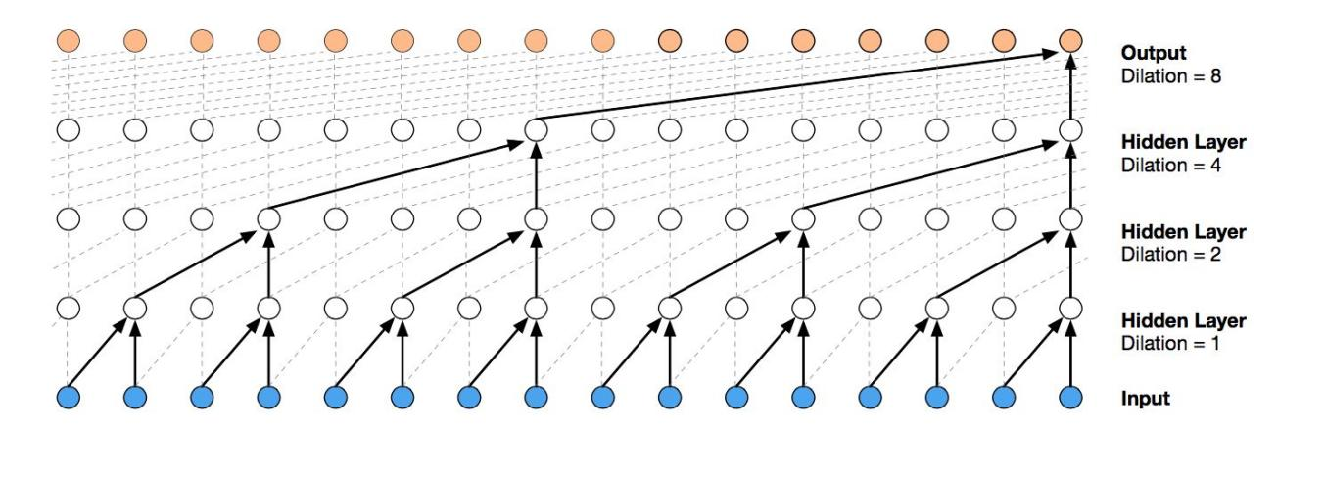

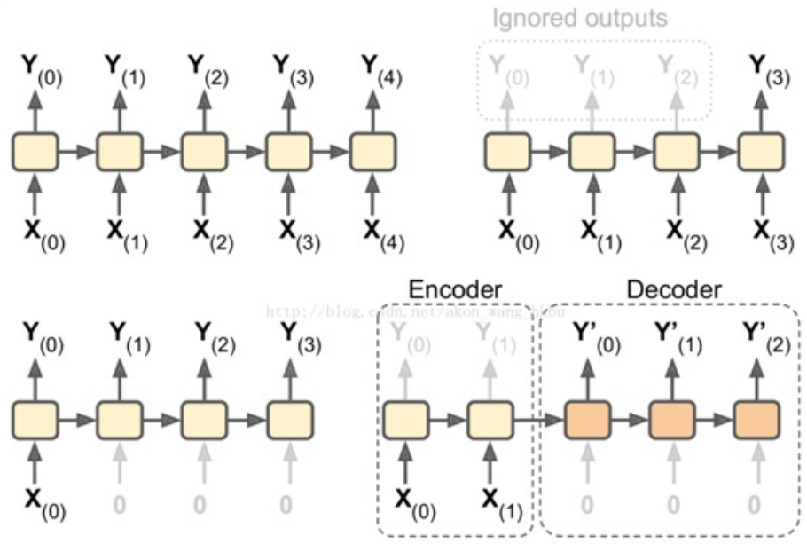
**Seq to seq(top left)**,seq to vector(top right),vector to seq(bottom left),delayed seq to seq(bottom right)

In [ ]:
for net_type in ['4g','5g']:
    if net_type == '4g':
        gselect_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有效RRC连接平均数', '下行流量', '上行流量', '下行利用率PDCCH']
    else:
        gselect_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有数据传输的RRC数', '下行流量', '上行流量', '下行利用率PDCCH']
    for city_name in city_list:
        train_file_path = './Datasets_new_IQR_100/{}_pm_202105_{}.pic'.format(net_type,city_name)
        test_file_path = './Datasets_new_IQR_100/{}_pm_202106_{}.pic'.format(net_type,city_name)
        for select_data_column in gselect_data_columns:
            result_data_path = './result_data_IQR05/{}_{}_{}.csv'.format(net_type,data_col_dict[select_data_column],city_name)
            print('begin to create {}'.format(result_data_path))
            if os.path.exists(result_data_path):
                print('there is already file {} exists'.format(result_data_path))
                continue
            out_file = "./temple_file/train_test_data_{}_{}_{}.pic".format(net_type,city_name,select_data_column)
            print('begin to create {}'.format(out_file))
            if os.path.exists(out_file):
                print('there is already file {} exists'.format(out_file))
                X_train,Y_train,X_test,scale_param,index_Y_train,index_X_test = train_data_load(out_file)
            else:
                print('begin to prapare data to train')
                #float_type = data_float_dict[select_data_column]
                float_type = 'float32'
                #data_select_radio = study_radio_dict[net_type][city_name]
                #data_select_radio = 24
                df,choose_cell_set,user_num = pic_to_pd_train(train_file_path,test_file_path,select_data_column,float_type,
                                                  select_cell_list = select_cell_dict_train[net_type][city_name])
                X_train,Y_train,index_Y_train = pd_to_npdata(df,select_data_column,train_month = 5,user_num = user_num)
                X_test,index_X_test = pd_to_npdata_test(test_file_path,select_data_column,float_type,test_month = 6,n_steps = 21)
                del(df)
                [X_train,Y_train,X_test],scale_param = all_data_scaler([X_train,Y_train,X_test])
                train_data_dump(out_file,[X_train,Y_train,X_test,scale_param,index_Y_train,index_X_test])
                print('{} data dump success'.format(out_file))
            scale_median = np.median(X_train)/5
            #ins_low = np.percentile(X_train,10)
            #ins_low = scale_median/4
            log_str = 'scale_median is {}'.format(scale_median)
            print(log_str)
            #log_str = 'ins_low is {}'.format(ins_low)
            #print(log_str)
            #Y_train[Y_train < ins_low] = ins_low
            X_train_dnn, X_valid_dnn = train_test_split(X_train, test_size=0.3, random_state=2012)
            Y_train_dnn, Y_valid_dnn = train_test_split(Y_train, test_size=0.3, random_state=2012)
            del(X_train)
            del(Y_train)
            Y_pred_copy = X_valid_dnn[:,-7:,0].copy()
            Y_true_sub = Y_valid_dnn[:,-1,:].copy()
            simple_mse = np.mean(keras.losses.mean_squared_error(Y_true_sub, Y_pred_copy))
            log_str = 'The simple_mse of {}_{}_{} is {}. Time:{}'.format(net_type,city_name,select_data_column,
                                                                        simple_mse,datetime.datetime.now())
            print(log_str)
            log_txt(log_str)
            Y_pred_copy[Y_true_sub == 0] = 0.01
            Y_true_sub[Y_true_sub == 0] = Y_pred_copy[Y_true_sub == 0]
            simple_mape = np.mean(keras.losses.mape(Y_true_sub, Y_pred_copy))
            log_str = 'The simple_mape of {}_{}_{} is {}. Time:{}'.format(net_type,city_name,select_data_column,
                                                                        simple_mape,datetime.datetime.now())
            print(log_str)
            log_txt(log_str)
            log_txt('-'*88)
            model_file_path = "./temple_file/{}_{}_{}_model_wave21newIQR5f.h5".format(net_type,select_data_column,city_name)
            if os.path.exists(model_file_path):
                print('there is already file {} exists'.format(model_file_path))
                model = keras.models.load_model(model_file_path,
                                                custom_objects = {'mape_handel':creat_mape_handel(scale_median,1)})
            else:
                patience_select = int(11000/len(select_cell_dict_train[net_type][city_name])* 3)
                print("patience_select is {}".format(patience_select))
                epochs_select = int(11000/len(select_cell_dict_train[net_type][city_name])* 25)
                print("epochs_select is {}".format(epochs_select))
                np.random.seed(42)
                tf.random.set_seed(42)
                model = keras.models.Sequential()
                model.add(keras.layers.InputLayer(input_shape=[None, 1]))
                for rate in (1, 2, 4, 8) * 2:
                    model.add(keras.layers.Conv1D(filters=80, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
                model.add(keras.layers.Conv1D(filters=7, kernel_size=1))
                checkpoint_cb = keras.callbacks.ModelCheckpoint(model_file_path,save_best_only=True)
                early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience_select,
                                                                  restore_best_weights=True)
                model.compile(loss=creat_mape_handel(scale_median,1), optimizer="adam")
                #model.compile(loss="mape", optimizer="adam")
                history = model.fit(X_train_dnn, Y_train_dnn, epochs=epochs_select,
                                    validation_data=(X_valid_dnn, Y_valid_dnn),
                                    callbacks = [checkpoint_cb, early_stopping_cb])
            Y_pred_sub = model.predict(X_valid_dnn)[:,-1,:]
            simple_mse = np.mean(keras.losses.mean_squared_error(Y_valid_dnn[:,-1,:], Y_pred_sub))
            log_str = 'The line_mse of {}_{}_{} is {}. Time:{}'.format(net_type,city_name,select_data_column,
                                                                        simple_mse,datetime.datetime.now())
            print(log_str)
            log_txt(log_str)
            Y_true_sub = Y_valid_dnn[:,-1,:].copy()
            Y_pred_copy = Y_pred_sub.copy()
            Y_pred_copy[Y_true_sub == 0] = 0.01
            Y_true_sub[Y_true_sub == 0] = Y_pred_copy[Y_true_sub == 0]
            simple_mape = np.mean(keras.losses.mape(Y_true_sub, Y_pred_copy))
            log_str = 'The line_mape of {}_{}_{} is {}. Time:{}'.format(net_type,city_name,select_data_column,
                                                                        simple_mape,datetime.datetime.now())
            print(log_str)
            log_txt(log_str)
            log_txt('='*88)
            Y_test = model.predict(X_test)[:,-1,:]
            Y_pred = scale_param.inverse_transform(Y_test.reshape(-1,1)).reshape(Y_test.shape)
            test_usenum  = int(len(Y_pred)/24)
            print('test_usenum is {}'.format(test_usenum))
            """
            for time_order in range(24):
                print("now time_order is {}".format(time_order))
                columns_name = []
                for day_order in range(7):
                    columns_name.append(24 * day_order + time_order + 1)
                start_row = time_order * test_usenum
                end_row = (time_order + 1) * test_usenum
                sub_data = pd.DataFrame(Y_pred[start_row:end_row],columns = columns_name,
                                        index = index_X_test.iloc[start_row:end_row].UserLabel)
                sub_data.index.name = "UserLabel"
                if time_order == 0:
                    final_sub_data = sub_data
                else:
                    final_sub_data = final_sub_data.merge(sub_data,left_index=True, right_index=True)
            final_sub_data.sort_index(axis = 1,inplace = True)
            columns_name = {}
            for order_num in range(1,169):
                columns_name[order_num] = "预测未来{}小时".format(order_num)
            final_sub_data.rename(columns  = columns_name,inplace = True)
            """
            Y_pred = Y_pred.reshape(24,test_usenum,7)
            Y_pred = Y_pred.transpose((1,2,0))
            Y_pred = Y_pred.reshape(test_usenum,168)
            columns_name = []
            for order_num in range(1,169):
                columns_name.append("预测未来{}小时".format(order_num))
            sub_data = pd.DataFrame(Y_pred,columns = columns_name,index = index_X_test.UserLabel[:test_usenum])
            #指标数据不可能小于0，剔除异常预测
            sub_data[sub_data < 0] = 0
            print("begin output_data in {}".format(result_data_path))
            sub_data.to_csv(result_data_path,encoding= 'gbk')
            print("success output_data in {}".format(result_data_path))
            keras.backend.clear_session()
            del(X_train_dnn, X_valid_dnn,Y_train_dnn, Y_valid_dnn, Y_pred, X_test, Y_test)
            del(index_Y_train,index_X_test)
            del(sub_data)
            if os.path.exists(out_file):  # 如果文件存在
                # 删除文件，可使用以下两种方法。
                os.remove(out_file)
                # os.unlink(path)
            else:
                print('no such file:%s' % out_file)  # 则返回文件不存在

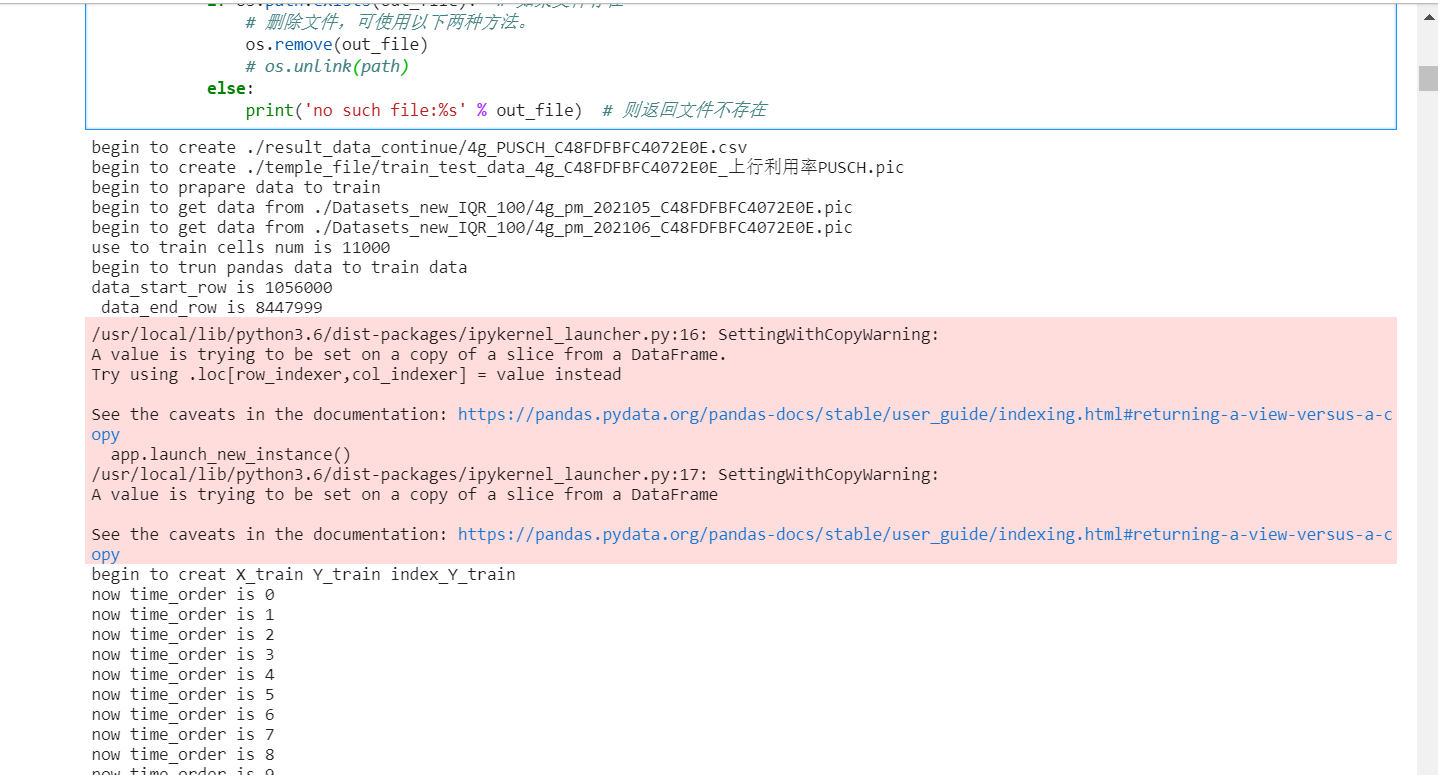

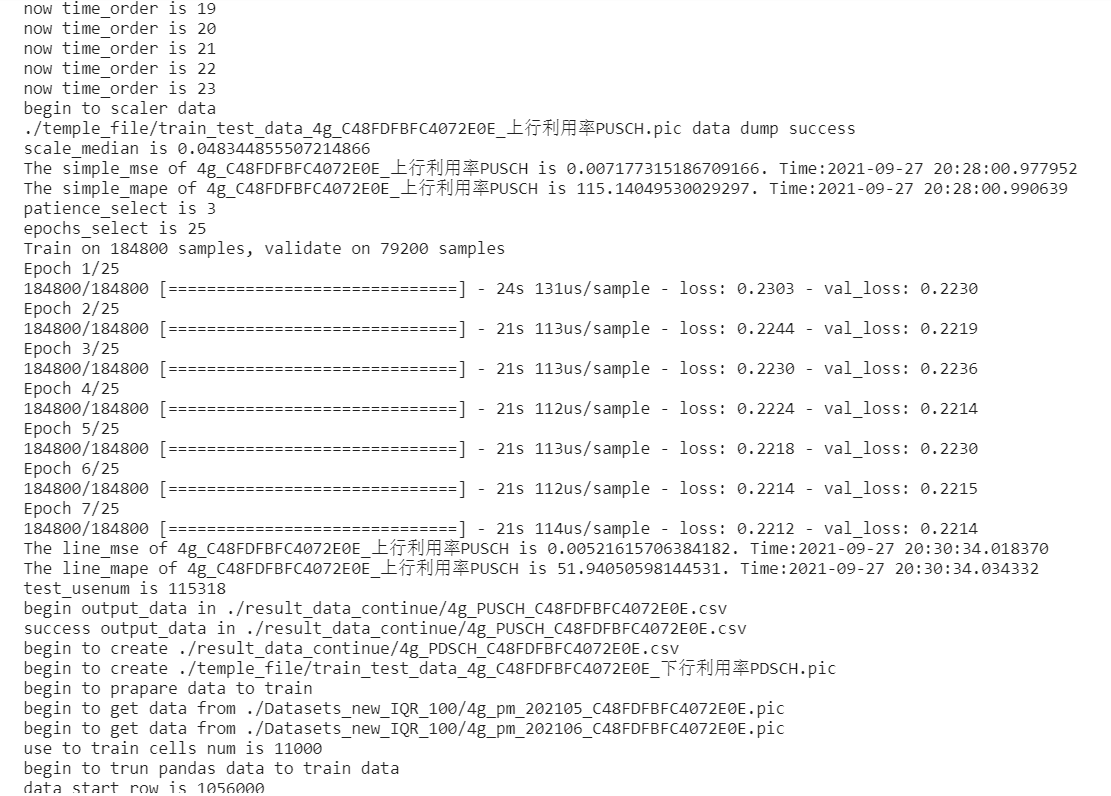

**在tensorflow中LSTM/GRU已经优化快于RNN，但对比conv1d仍然慢很多，使用1 V100下LSTM/GRU超过3层每sample约200-300us，而wavenet约100-150us。（如上截图所示,可与Other03同部分对比）**

**In tensorflow, LSTM/GRU has been optimized to be faster than RNN, but it is still much slower than conv1d. When using 1 V100, LSTM/GRU exceeds 3 layers and each sample is about 200-300us, while wavenet is about 100-150us.（shown in the screenshot ahead,you can compare with same part of Other03 code )**

In [ ]:
end_time = datetime.datetime.now()
log_str = 'end_time is {}'.format(end_time)
print(log_str)
log_txt(log_str)
all_use_time = (end_time - start_time)
log_str = 'all_use_time is {}'.format(all_use_time)
print(log_str)
log_txt(log_str)

**the end time of code running and all use time is about 5 hours**

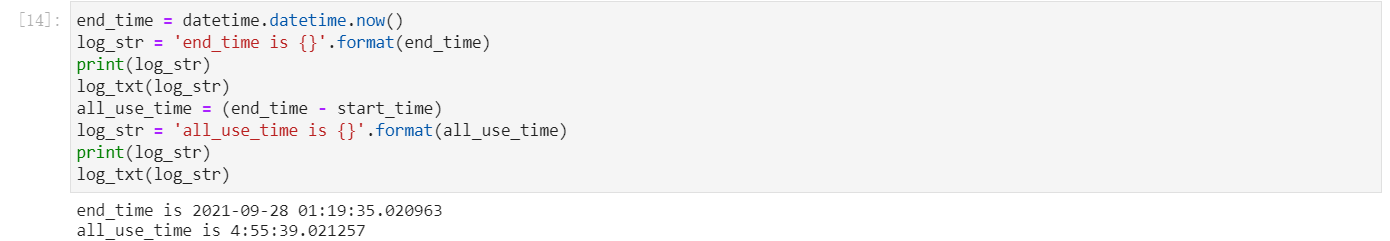

In [ ]:
import zipfile

In [ ]:
def compressFolder(folderPath, compressPathName):
    '''
    :param folderPath: 文件夹路径
    :param compressPathName: 压缩包路径
    :return:
    '''
    zip = zipfile.ZipFile(compressPathName, 'w', zipfile.ZIP_DEFLATED)
    for path, dirNames, fileNames in os.walk(folderPath):
        for name in fileNames:
            fullName = os.path.join(path, name)
            name = "result_data" + '/' + name
            print(fullName)
            print(name)
            zip.write(fullName, name)
    zip.close()

In [ ]:
folderPath = './result_data_IQR05'
compressPathName = './result_data.zip'
compressFolder(folderPath, compressPathName)

In [ ]:
!curl --location --request POST 'http://36.133.53.121:1080/file/upload' --form 'cloud_id=CIDC-U-6fca7a4e9f9645f0abe69ea1df9f7e26' --form 'file=@result_data.zip'

**Here we get a 0.2562(mape)，the work demo is 0.2563,because in the loss function, ins_low = scale_median is different here**

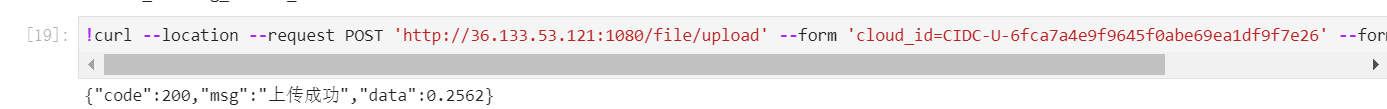